# adam testing
## a little bit smaller

this is a plot of my stuff
$$

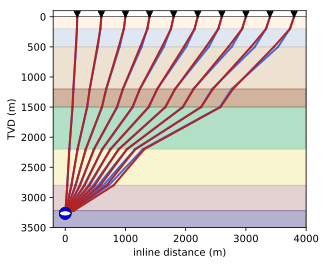

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from obspy.imaging.mopad_wrapper import beach

from raytrace import traceRaysIso
from waveform_model import get_response

# coordinate system xyz -> NED
# color scheme N --> steelblue
#              E --> firebrick
#              D --> goldenrod
def sqa(x):
    return(np.squeeze(np.array(x)))
    
stations = []
for iy in np.arange(0, 4000, 400):
    stations.append({"x": 200 + iy, "y": 0, "z": 0.})

velocityModel = [
    {"rho": 2100, "vp": 2000., "vs": 1200., "color": "bisque"},
    {"rho": 2200, "vp": 4100., "vs": 2000., "top": 200., "color": "lightsteelblue"},
    {"rho": 2300, "vp": 4300., "vs": 2700., "top": 500., "color": "tan"},
    {"rho": 2300, "vp": 3500., "vs": 2000., "top": 1200., "color": "saddlebrown"},
    {"rho": 2400, "vp": 5400., "vs": 3200., "top": 1500., "color": "mediumseagreen"},
    {"rho": 2400, "vp": 4000., "vs": 2500., "top": 2200., "color": "khaki"},
    {"rho": 2400, "vp": 5200., "vs": 3000., "top": 2800., "color": "rosybrown"},
    {"rho": 2400, "vp": 5890., "vs": 3400., "top": 3220., "color": "darkslateblue"}
]

Q = {"P": 80, "S": 60}

source = {"x": 0, "y": 0., "z": 3265,
          "moment_magnitude": -0.2,
          "stress_drop": 1e5,  # static stress drop
          "moment_tensor": np.matrix([[1., 0., 0.],
                                      [0., 0., 0.],
                                      [0., 0., -1.]])
          }

m11,m12,m13,d1,m22,m23,d2,d3,m33 = sqa(source["moment_tensor"].reshape(9,))
mt_6 = [m11,m22,m33,m12,m13,m23]
source["moment_tensor"] = (source["moment_tensor"] /
                           np.linalg.norm(source["moment_tensor"]))
top, bottom = 0, 3500
f0, a0 = plt.subplots()
a0.set_aspect('equal')
top_patch = mpatches.Rectangle([-200, top], 4200, velocityModel[1]['top'] - top,
                               color=velocityModel[0]['color'], alpha=0.4,
                               edgecolor='k', linewidth=1,zorder=-1)
a0.add_patch(top_patch)
ii = 1
for layer in velocityModel[1:-1]:
    ii += 1
    layer_patch = mpatches.Rectangle([-200, layer['top']], 4200,
                                     velocityModel[ii]['top'] - layer['top'],
                                     color=layer['color'], alpha=0.4,
                                     edgecolor='k', linewidth=1, zorder=-1)
    a0.add_patch(layer_patch)
bottom_patch = mpatches.Rectangle([-200, velocityModel[-1]['top']], 4200,
                                  bottom - velocityModel[-1]['top'],
                                  color=velocityModel[-1]['color'], alpha=0.4,
                                  edgecolor='k', linewidth=1,zorder=-1)
a0.add_patch(bottom_patch)
time_series = np.arange(0, 4.00, 0.001)
waveforms = []
max_waveform = 0
for ii in range(len(stations)):
    pRaypath = traceRaysIso(source, stations[ii], velocityModel, "P")
    sRaypath = traceRaysIso(source, stations[ii], velocityModel, "S")
    waveforms.append(get_response(pRaypath, sRaypath, source,
                                  stations[ii], Q, time_series))
    mwave = max([max(abs(waveforms[-1]['n'])),
                 max(abs(waveforms[-1]['e'])),
                 max(abs(waveforms[-1]['d']))])
    if max_waveform < mwave: max_waveform = mwave
    p_slow = pRaypath['hrz_slowness']
    s_slow = sRaypath['hrz_slowness']
    x1, y1, z1 = source['x'], source['y'], source['z']
    for layer in sRaypath['velocity_model_chunk']:
        segment_time = (abs(layer['h']) / layer['v'] /
                        np.sqrt(1 - layer['v'] * layer['v'] *
                                (s_slow['x'] * s_slow['x'] + 
                                 s_slow['y'] * s_slow['y'])))
        x2 = x1 - segment_time * s_slow['x'] * layer['v'] * layer['v']
        y2 = y1 - segment_time * s_slow['y'] * layer['v'] * layer['v']
        z2 = z1 - layer['h']
        a0.plot([x1, x2], [z1, z2], 'royalblue', lw=2,zorder=0)
        x1, y1, z1 = x2, y2, z2
    x1, y1, z1 = source['x'], source['y'], source['z']
    for layer in pRaypath['velocity_model_chunk']:
        segment_time = (abs(layer['h']) / layer['v'] /
                        np.sqrt(1 - layer['v'] * layer['v'] *
                                (p_slow['x'] * p_slow['x'] + 
                                 p_slow['y'] * p_slow['y'])))
        x2 = x1 - segment_time * p_slow['x'] * layer['v'] * layer['v']
        y2 = y1 - segment_time * p_slow['y'] * layer['v'] * layer['v']
        z2 = z1 - layer['h']
        a0.plot([x1, x2], [z1, z2], 'firebrick', lw=2,zorder=1)
        x1, y1, z1 = x2, y2, z2
for station in stations:
    a0.plot(station['x'], station['z'] - 40, 'kv')
a0.plot([-200, 4000], [0, 0], 'k', lw=0.5)
a0.set_ylim([bottom, top - 100])
a0.set_xlim([-200, 4000])
a0.set_ylabel('TVD (m)')
a0.set_xlabel('inline distance (m)')

fig, ax = plt.subplots()
for ii in range(len(waveforms)):
    ax.plot(0.8 * waveforms[ii]['n'] / max_waveform + ii + 0.9,
            time_series, color='steelblue')
    ax.plot(0.8 * waveforms[ii]['e'] / max_waveform + ii + 1.0,
            time_series, color='firebrick')
    ax.plot(0.8 * waveforms[ii]['d'] / max_waveform + ii + 1.1,
            time_series, color='darkgoldenrod')
    
beach_ball = beach(mt_6, xy=(source["x"],source["z"]),zorder=2,
                      width=200,mopad_basis="NED",linewidth=0.5)
a0.add_collection(beach_ball)
ax.set_ylabel('time (s)')
ax.set_xlabel('station')
ax.set_xticks(range(1, len(stations) + 1))
ax.set_xlim([0, len(waveforms) + 1])
ax.set_ylim([time_series[-1], time_series[0]])

plt.show()
